# Omówienie modelu przygotowanych na konkurs Quora Question Pairs

### Piotr Rybak<br/>Tomek Korbak

# Przygotowane modele

| id | log loss na Kaggle'u | opis | kto zrobił |
| --- | --- | --- | --- |
| 1  |  0,39 | syjamska sieć rekurencyjna z komórkami LSTM | Tomek |
| 2  |  0,44| ?? | Piotrek  |
| 3  |  0,43| ?? | Piotrek  |
| 4  |  0,40| ?? | Piotrek  |
| 5  |  0,45| ?? | Piotrek  |
| 6 |  0,42| ?? | Piotrek  |
| 7  |  0,74 | syjamski dwukierunkowy LSTM z ostatnią warstwą obliczającą normę l2 między reprezentacjami zdań | Tomek |
| 8  |  0,46 | syjamski podwójny dwukierunkowy LSTM z uwagą| Tomek |
| 9  |  0,35 | średnia modeli 1 i 4 | Piotrek i Tomek |


In [16]:
# UKRYTY SLAJD: NUDNY KOD POTRZEBY ZEBY NIZEJ WSZYSTKO DZIALALO

from IPython.display import SVG

from keras.models import Model
from keras.layers import Dense, Dropout, Input, LSTM, Embedding, \
Bidirectional, Lambda, RepeatVector, merge, Permute, Reshape
from keras.layers.merge import concatenate, multiply
from keras.callbacks import EarlyStopping, ModelCheckpoint, ProgbarLogger, TensorBoard
from keras.layers.normalization import BatchNormalization
from keras import backend as K

class Config(object):
    VOCABULARY_SIZE = 1193514
    EMBEDDING_DIMENSION = 200
    OFFSET = 3
    OOV_TOKEN = 0  # out of vocabulary
    EOS_TOKEN = 1  # end of sentence
    PAD_TOKEN = 2  # padding to max sentence length
    MAX_SENTENCE_LENGTH = 60
    DENSE_LAYER_SIZE = 150
    DROPOUT = 0.4
    
current_config = Config()

# Syjamska architektura sieci neuronowej

Architektura syjamska to tradycyjne podejście do modeli porównujących dwa wejścia tego samego typu: warstwy wydobywające cechy obiektów na wejściu mają wspólne wagi.

![](https://www.researchgate.net/profile/Gregoire_Lefebvre/publication/260452382/figure/fig2/AS:297249520275457@1447881216257/Figure-2-A-Siamese-Neural-Network.png)

# Syjamska sieć rekurencyjna z komórkami LSTM

In [24]:
shared_lstm_layer = LSTM(
    units=100, 
    return_sequences=False, 
    go_backwards=True, 
    dropout=0.3
)
shared_embedding_layer = Embedding(
    input_dim=current_config.VOCABULARY_SIZE + current_config.OFFSET, 
    output_dim=current_config.EMBEDDING_DIMENSION, 
    input_length=current_config.MAX_SENTENCE_LENGTH,
    trainable=False
)

input_A = Input(shape=(current_config.MAX_SENTENCE_LENGTH,))
embeddings_A = shared_embedding_layer(input_A)
sentence_representation_A = shared_lstm_layer(embeddings_A)

input_B = Input(shape=(current_config.MAX_SENTENCE_LENGTH,))
embeddings_B = shared_embedding_layer(input_B)
sentence_representation_B = shared_lstm_layer(embeddings_B)

merged_model = concatenate([sentence_representation_A, sentence_representation_B])
dropout_1 = Dropout(current_config.DROPOUT)(merged_model)
dense_1 = Dense(current_config.DENSE_LAYER_SIZE)(dropout_1)
dropout_2 = Dropout(current_config.DROPOUT)(dense_1)
merged = BatchNormalization()(dropout_2)

predictions = Dense(1, activation='sigmoid')(merged)

model_1 = Model(inputs=[input_A, input_B], outputs=predictions)
model_1.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_1.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_13 (InputLayer)            (None, 60)            0                                            
____________________________________________________________________________________________________
input_14 (InputLayer)            (None, 60)            0                                            
____________________________________________________________________________________________________
embedding_8 (Embedding)          (None, 60, 200)       238703400   input_13[0][0]                   
                                                                   input_14[0][0]                   
____________________________________________________________________________________________________
lstm_15 (LSTM)                   (None, 100)           120400      embedding_8[0][0]       

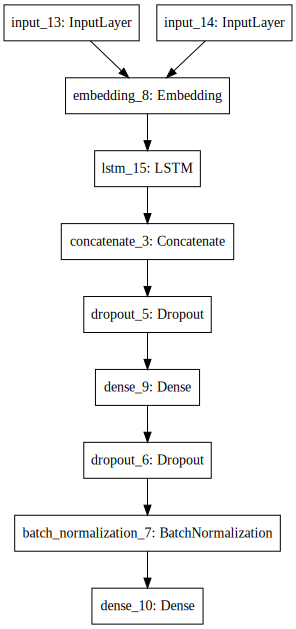

In [25]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model_1).create(prog='dot', format='svg'))

# Syjamski dwukierunkowy LSTM z ostatnią warstwą obliczającą normę l2 różnicy między reprezentacjami zdań

Cel sieci jest zdefiniowany explicite jaki minimalizacja odległości euklidesowej (l2) pomiędzy wektorowymi reprezentacjami pytań, jeśli pytania są swoimi parafrazami (lub jej maksymalizacja w przeciwnym wypadku).

$$\begin{align}\mathrm{d}(\mathbf{p},\mathbf{q}) = \mathrm{d}(\mathbf{q},\mathbf{p}) & = \sqrt{(q_1-p_1)^2 + (q_2-p_2)^2 + \cdots + (q_n-p_n)^2} \\[8pt]
& = \sqrt{\sum_{i=1}^n (q_i-p_i)^2}.\end{align}$$

In [26]:
def euclidean_distance(vectors):
    x, y = vectors
    return K.sqrt(
        K.maximum(
            K.sum(K.square(x - y), axis=1, keepdims=True), 
            K.epsilon()
        )
    )

shared_lstm_layer = Bidirectional(
    LSTM(units=100, 
         return_sequences=False, 
         dropout=0.3)
)

shared_embedding_layer = Embedding(
    input_dim=current_config.VOCABULARY_SIZE + current_config.OFFSET, 
    output_dim=current_config.EMBEDDING_DIMENSION, 
    input_length=current_config.MAX_SENTENCE_LENGTH,
#     weights=[embedding_weights],
    trainable=False
)

input_A = Input(shape=(current_config.MAX_SENTENCE_LENGTH,))
embeddings_A = shared_embedding_layer(input_A)
sentence_representation_A = shared_lstm_layer(embeddings_A)

input_B = Input(shape=(current_config.MAX_SENTENCE_LENGTH,))
embeddings_B = shared_embedding_layer(input_B)
sentence_representation_B = shared_lstm_layer(embeddings_B)


distance = Lambda(euclidean_distance)(
    [sentence_representation_A, 
    sentence_representation_B]
)

predictions = Dense(1, activation='sigmoid')(distance)

model_2 = Model(inputs=[input_A, input_B], outputs=predictions)
model_2.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_2.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_15 (InputLayer)            (None, 60)            0                                            
____________________________________________________________________________________________________
input_16 (InputLayer)            (None, 60)            0                                            
____________________________________________________________________________________________________
embedding_9 (Embedding)          (None, 60, 200)       238703400   input_15[0][0]                   
                                                                   input_16[0][0]                   
____________________________________________________________________________________________________
bidirectional_13 (Bidirectional) (None, 200)           240800      embedding_9[0][0]       

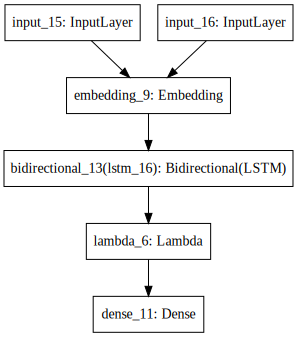

In [27]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model_2).create(prog='dot', format='svg'))

# Syjamski podwójny dwukierunkowy LSTM z uwagą

Mechanizm uwagi to wektor wag nakładający maskę na wyjście komórki LSTM w każdym kroku czasowym

In [17]:
def shared_attention(inputs):
    a = Permute((2, 1))(inputs)
    a = Reshape(
        target_shape=(current_config.EMBEDDING_DIMENSION, 
                      current_config.MAX_SENTENCE_LENGTH)
    )(a)
    a = Dense(current_config.MAX_SENTENCE_LENGTH, activation='softmax')(a)
    a = Lambda(lambda x: K.mean(x, axis=1))(a)  
    a = RepeatVector(n=current_config.EMBEDDING_DIMENSION)(a)
    a_probs = Permute(dims=(2, 1))(a)
    output_attention_mul = multiply([inputs, a_probs])
    return output_attention_mul

shared_lstm_layer_1 = Bidirectional(
    LSTM(units=100, 
         return_sequences=True, 
         dropout=0.4)
)

shared_lstm_layer_2 = Bidirectional(
    LSTM(units=100, 
         return_sequences=False, 
         dropout=0.4)
)

shared_embedding_layer = Embedding(
    input_dim=current_config.VOCABULARY_SIZE + current_config.OFFSET, 
    output_dim=current_config.EMBEDDING_DIMENSION, 
    input_length=current_config.MAX_SENTENCE_LENGTH,
#     weights=[embedding_weights],
    trainable=False
)

input_A = Input(shape=(current_config.MAX_SENTENCE_LENGTH,))
embeddings_A = shared_embedding_layer(input_A)
initial_representation_A = shared_lstm_layer_1(embeddings_A)
norm_initial_representation_A = BatchNormalization()(initial_representation_A)
attended_representation_A = shared_attention(initial_representation_A)
sentence_representation_A = shared_lstm_layer_2(attended_representation_A)

input_B = Input(shape=(current_config.MAX_SENTENCE_LENGTH,))
embeddings_B = shared_embedding_layer(input_B)
initial_representation_B = shared_lstm_layer_1(embeddings_B)
norm_initial_representation_B = BatchNormalization()(initial_representation_B)
attended_representation_B = shared_attention(initial_representation_B)
sentence_representation_B = shared_lstm_layer_2(attended_representation_B)

merged_model = concatenate([sentence_representation_A, sentence_representation_B])
dropout_1 = Dropout(current_config.DROPOUT)(merged_model)
dense_1 = Dense(current_config.DENSE_LAYER_SIZE)(dropout_1)
dropout_2 = Dropout(current_config.DROPOUT)(dense_1)
merged = BatchNormalization()(dropout_2)

predictions = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[input_A, input_B], outputs=predictions)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_11 (InputLayer)            (None, 60)            0                                            
____________________________________________________________________________________________________
input_12 (InputLayer)            (None, 60)            0                                            
____________________________________________________________________________________________________
embedding_7 (Embedding)          (None, 60, 200)       238703400   input_11[0][0]                   
                                                                   input_12[0][0]                   
____________________________________________________________________________________________________
bidirectional_11 (Bidirectional) (None, 60, 200)       240800      embedding_7[0][0]       

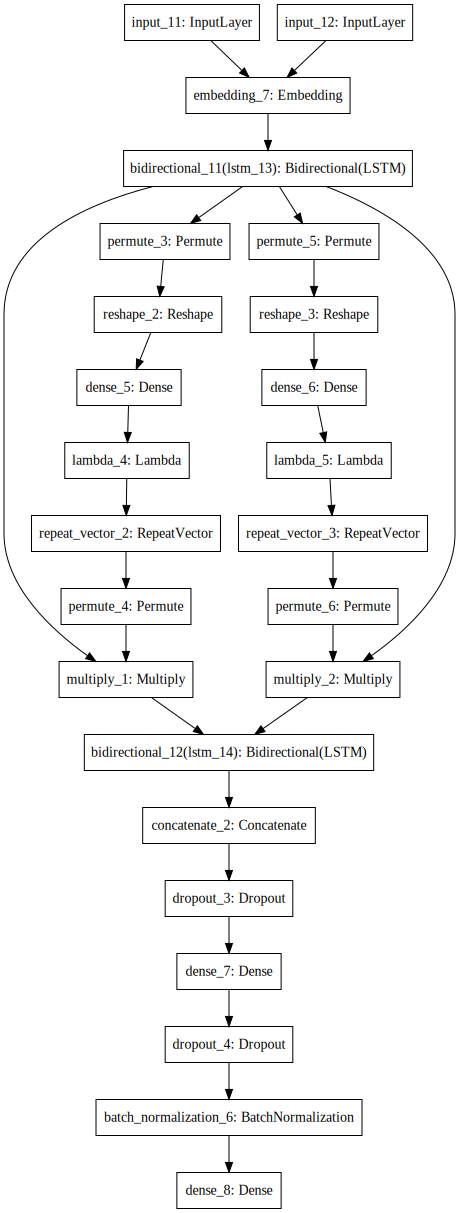

In [22]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

# Miejsce na slajdy Piotrka

# Dziękujemy za uwagę